Define the problem with PySCF and initialize the qubit mapper and ansatz with Qiskit.

In [9]:
from __future__ import annotations

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint

driver = PySCFDriver(atom="H 0 0 0; H 0 0 0.735", basis="sto-3g")
problem = driver.run()

mapper = JordanWignerMapper()

ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)


Define VQE and the corresponding OSCAR executor.

In [10]:
from qiskit.algorithms.optimizers import SLSQP
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit_aer.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from oscar import QiskitExecutor

vqe = VQE(
    Estimator(run_options={"shots": None}, approximation = True),
    ansatz,
    SLSQP(),
)
solver = GroundStateEigensolver(mapper, vqe)
operator, _ = solver.get_qubit_operators(problem)
executor = QiskitExecutor(vqe, operator)


Define the landscape grid and run grid points. This may take a while.

In [11]:
from math import pi
from oscar import Landscape, plot_2d_landscape

n_params = ansatz.num_parameters
resolution = [25] * n_params
bounds = (-pi / 2, pi / 2)

landscape = Landscape(resolution, bounds)
_ = landscape.run_all(executor)


Optionally, run a normal optimiztion so we can plot the optimization trace over the landscape.

In [12]:
from oscar import NLoptOptimizer, QiskitOptimizer

trace, original_result = NLoptOptimizer("LN_COBYLA").run(
    executor, initial_point=[0] * n_params, bounds=[bounds] * n_params, xtol_abs=1e-11
)
trace.print_result()


Total time: 0.43811821937561035
Optimal parameters reported:  [-7.35059489e-08 -7.54427263e-10 -1.11768525e-01]
Optimal value reported:  -1.857275030202374
Number of evaluations:  113


To get 2D landscapes suitable for visualization, we get a slice of the high-dimensional landscape to plot. In the below example, we slice the 3D landscape by fixing the first, second, and the third parameter respectively to 0 (corresponding to index 12 in our grid definition). Note the 3D trace is projected on to the slice by specifying `trace_plot_params`.

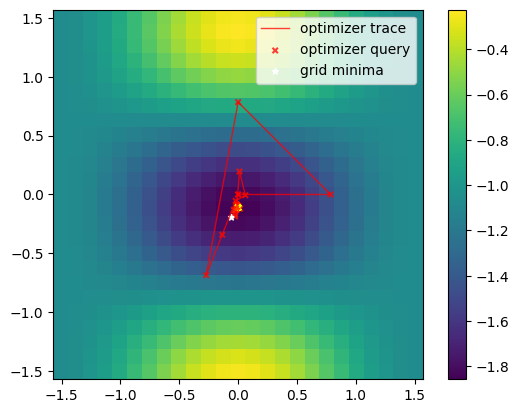

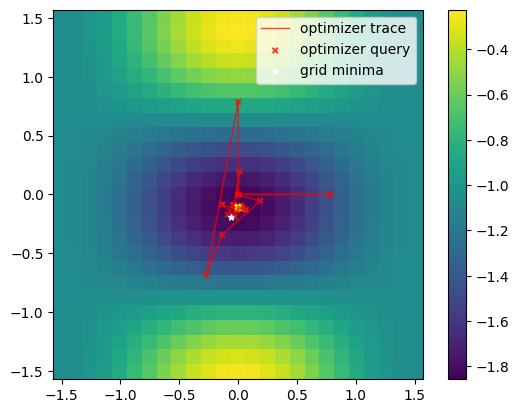

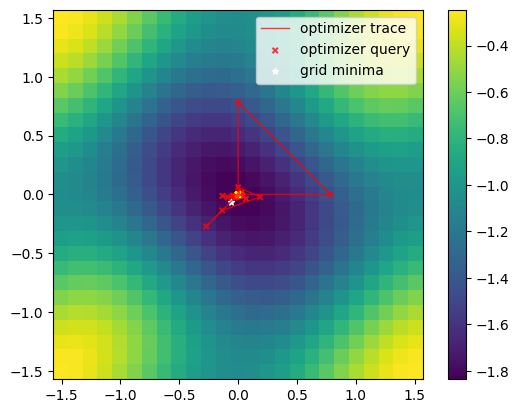

In [13]:
plot_2d_landscape(landscape[12], trace, trace_plot_params = (1, 2))
plot_2d_landscape(landscape[:, 12], trace, trace_plot_params = (0, 2))
_ = plot_2d_landscape(landscape[:, :, 12], trace)


Or we can fix one of the parameters to a desired value (optimizer-reported optimal parameter values in the below example) in the VQE definition to avoid computing the huge 3D landscape. We can also do a higher resolution this way.

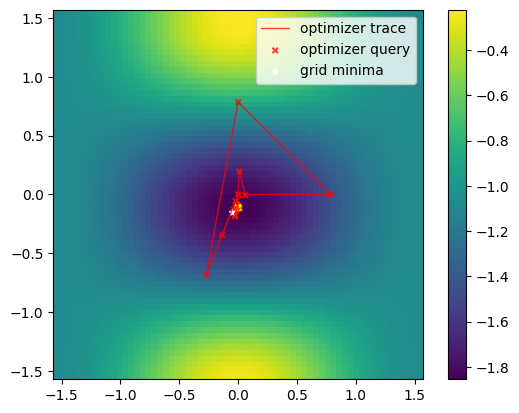

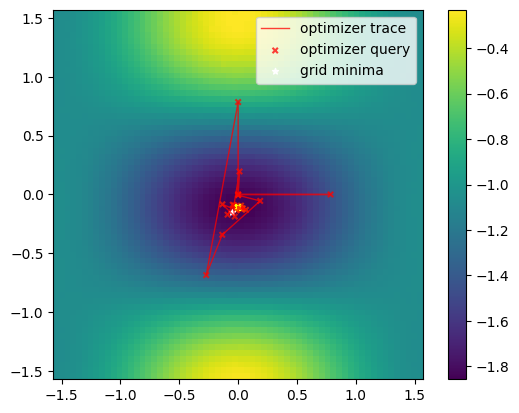

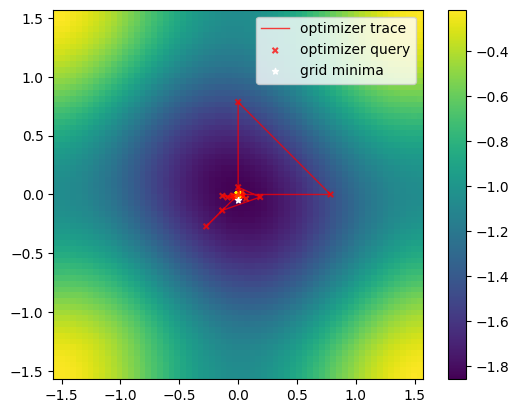

In [15]:
for i in range(len(ansatz.parameters)):
    vqe = VQE(
        Estimator(run_options={"shots": None}, approximation = True),
        ansatz.assign_parameters({ansatz.parameters[i]: trace.optimal_params[i]}), # fix one parameter
        SLSQP(),
    )
    solver = GroundStateEigensolver(mapper, vqe)
    operator, _ = solver.get_qubit_operators(problem)
    executor = QiskitExecutor(vqe, operator)
    landscape_slice = Landscape([64, 64], bounds)
    landscape_slice.sample_and_run(executor, sampling_fraction = 1 / 16)
    landscape_slice.reconstruct()
    plot_2d_landscape(landscape_slice, trace, [j for j in range(len(ansatz.parameters)) if j != i])
